# ICSP Contest 0706
## 藤原　大悟

# 目的：
Input:TMBOから出力されたCSVデータの時系列に対して，

output:ボールの位置判定（ボーダー左，ボーダー上,ボーダー右）のいずれかを出力

データが少ないのでとりあえずルールベースで実装する．

分類機を作成した後，16個の動画データに対して性能評価をする．

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

import cv2
import glob

import numpy as np

## データの読み取り
まずはcsvデータを読み取りデータの中身を表示してみる．
先頭から５行，行数列数も確認．

In [2]:
def get_dir_content(dir_name):
    load=glob.glob(dir_name)
    content_num=len(load)
    return load,content_num

In [3]:
#csvと動画のパスを取得
movie_path="/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/movies/*"
csv_path="/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/csv/*"

movie,movie_num=get_dir_content(movie_path)
csv,csv_num=get_dir_content(csv_path)

movie.sort()
csv.sort()

print(movie[0])
print(csv[0])

/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/movies/far-1.mp4
/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/csv/far-1.csv


In [6]:
#pandasデータフレームにcsvを読み取り
df=[]
time=[]

for i in range(csv_num):
    df.append(pd.read_csv(csv[i],header=0,sep=','))
    time.append(df[i].shape[0])
    
mesh_num=int(int(df[0].shape[1]-3)/12)


df[0].head()

,Time,Frame,baseFrame,Mesh No.,v,h,Invalid,Coefficient,Move x,Move y,...,h.575,Invalid.575,Coefficient.575,Move x.575,Move y.575,Difference.575,DifferenceAdj.575,NOverPixels.575,LMSN.575,Result.575
0,1562297995656,3,2,0,0,0,0,1.0,0,0,...,31,0,0.99,0,0,3.13,0.54,21,N,0
1,1562297995668,4,3,0,0,0,0,1.0,0,0,...,31,0,0.98,0,0,3.26,0.57,13,N,0
2,1562297995678,5,4,0,0,0,0,1.0,0,0,...,31,0,1.00,0,0,0.49,0.09,0,N,0
3,1562297995689,6,5,0,0,0,0,1.0,0,0,...,31,0,0.96,0,0,3.95,0.68,36,N,0
4,1562297995699,7,6,0,0,0,0,1.0,0,0,...,31,0,0.98,0,0,3.26,0.57,21,N,0


# １．分類機の作成：

## 手順１：白線の検出

動画の0フレーム目を画像として読み取り，比較的明度の高い場所を出力.
以下TMBO画像のマス目をメッシュ，画像のマス目をセルと呼び区別する．

In [7]:
def return_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("movie roding error !")

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)#パラメータCAP_PROP_POS_FRAMESにframe_numを指定

    ret, frame = cap.read() #frame_num番目の画像を取得

    if not ret :
        print("movie roding error !")

    return frame

In [8]:
frame0=return_frame(movie[0],0)

#グレースケールに変換
gray_frame0= cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)

cv2.imwrite('/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/frame0s/frame0.jpg', frame0)
cv2.imwrite('/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/gray_frame0s/gray_frame0.jpg', gray_frame0)

print("セルの(行数，列数)=",np.shape(gray_frame0))
cellvsize=np.shape(gray_frame0)[0]
cellhsize=np.shape(gray_frame0)[1]

セルの(行数，列数)= (540, 960)


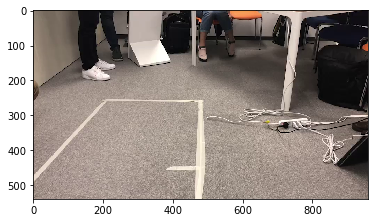

In [9]:

#カラー画像
plt.imshow(cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB))
plt.show()

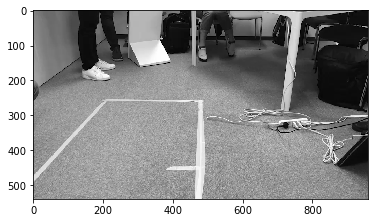

In [10]:

#グレースケール
plt.imshow(cv2.cvtColor(gray_frame0, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
threshold=238

白線の明度を確認，だいたい238くらい

In [12]:
#白線のみ抽出する関数
def get_whiteline(img,th,rate):

    u=th+rate
    l=th-rate

    U=img<u
    L=img>l

    temp=np.logical_and(U,L)

    is_white_line=temp.astype(np.int)

    white_line=is_white_line*img
    
    white_line=white_line.astype(np.uint8)
    
    return white_line,is_white_line

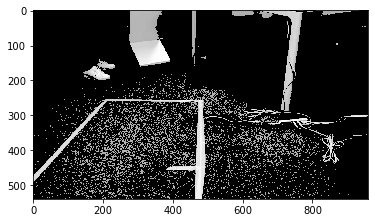

In [13]:
rate=70
white_line,is_white_line=get_whiteline(gray_frame0,threshold,rate)
plt.imshow(cv2.cvtColor(white_line, cv2.COLOR_BGR2RGB))
plt.show()

概ね白線を正しく検出できた.関係ない点も多いので平滑化をかける．

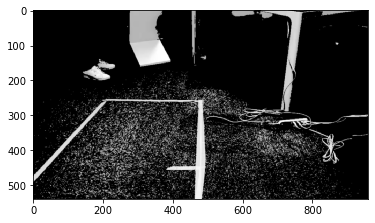

In [14]:

blur = cv2.GaussianBlur(white_line,(5,5),0)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
plt.show()

平滑化をかけた画像でさらにもう一度閾値あたりの画像を検出

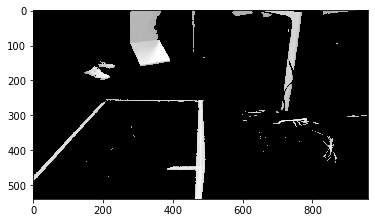

In [15]:
white_line,is_white_line=get_whiteline(blur,threshold,rate)
plt.imshow(cv2.cvtColor(white_line, cv2.COLOR_BGR2RGB))
plt.show()

これでOK．
ここから，白線より右か左かもis_white_lineにフラグづけしておきましょう

In [16]:
for i in range(is_white_line.shape[0]):
    flag=0
    for j in range(is_white_line.shape[1]):
        if is_white_line[i,j]==1 and j>200:
            flag=1
        if flag==0:
            is_white_line[i,j]=-1

この前処理で白線より左は-1,白線上は1,白線より右は0にフラグづけされた．
座標(400,300)，(400,480)，(400,600)で確認してみよう

In [17]:
print("(400,300)=",is_white_line[400,200],",(400,400)=",is_white_line[400,480],",(400,600)=",is_white_line[400,600])

(400,300)= -1 ,(400,400)= 1 ,(400,600)= 0


## 手順２　CSVデータによるボールの位置検出

フラグがM,L（＝活性化している）のメッシュをボールの位置と考え近似する．
これによりボールの位置をメッシュ単位で求める．

In [18]:
#名前の格納
LMSNs=["LMSN"]

for i in range(1,mesh_num):
    LMSNs.append("LMSN."+str(i))

    
vend="v."+str(mesh_num-1)
hend="h."+str(mesh_num-1)
vsize=df[0][vend][0]+1
hsize=df[0][hend][0]+1

In [19]:
#dfからLMSN情報を取得
state=[]

for i in range(mesh_num):
    state.append(df[0][LMSNs[i]])

In [20]:
#各時間，各メッシュでのボールの有無
ball=np.zeros((time[0],vsize,hsize))

for t in range(time[0]):
    
    temp=np.zeros(mesh_num)
    
    for i in range(mesh_num):
        if state[i][t]=="L" :
            temp[i]=2
        elif state[i][t]=="M":
            temp[i]=1
    
    ball[t]=np.reshape(temp,(vsize,hsize))

In [21]:
#各時間，各セルでのボールの有無
cellball=np.zeros((time[0],cellvsize,cellhsize))

#ボールの位置（セル）
ballpos=[]

#ボールの重心（セル）
COG=np.zeros((time[0],2))

#L:Mの時の重み
wrate=3

dv=int(cellvsize/vsize)
dh=int(cellhsize/hsize)

#活性化メッシュのノイズフィルター（閾値以下のセル数で除去）
filt=dv*dh*3

for t in range(time[0]):
    for i in range(vsize):
        for j in range(hsize):
            if ball[t,i,j]==1:
                cellball[t][i*dv:(i+1)*dv,j*dh:(j+1)*dh]=np.ones((dv,dh))
            elif ball[t,i,j]==2:
                cellball[t][i*dv:(i+1)*dv,j*dh:(j+1)*dh]=2*np.ones((dv,dh))
    
    pointL=np.where(cellball[t]==2)
    pointL=np.array(pointL)
    
    pointM=np.where(cellball[t]==1)
    pointM=np.array(pointM)
    
    point=np.append(pointL,pointM,axis=1)
    
    w=np.append(wrate*np.ones(pointL.shape[1]),np.ones(pointM.shape[1]))
    
    #ボールが存在しないtの時は(nan,nan)とする,filt以下のセル数しか活性化してないなら画面内にボールは存在しない
    if point.shape[1]<filt:
        COG[t]=np.array([np.nan,np.nan])
        ballpos.append(np.array([[np.nan],[np.nan]]))
    else:
        COG[t]=np.average(point,axis=1,weights=w).astype(np.int)
        ballpos.append(point)

閾値以下の活性化セルしかない時は無視するようにノイズフィルタリングした．

アニメーションで活性化セルを確認

<IPython.core.display.Javascript object>


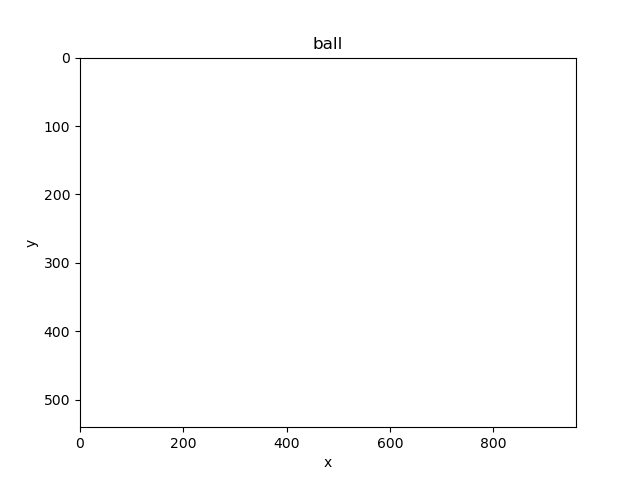

In [23]:
%matplotlib nbagg
fig1=plt.figure()
ims=[]

plt.title('ball')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim([540, 0])
plt.xlim([0, 960])

for i in range(time[0]):
    im=plt.plot(ballpos[i][1],ballpos[i][0],"o",color="g")
    ims.append(im)
    
ani = animation.ArtistAnimation(fig1, ims, interval=100)
plt.show()

## 手順３　ボールの重心軌道の補足と着地点の推定

ボールが存在しているセルの重み付き平均値(Lを重く)を求め，それを重心とする．重心の軌道を追う

重心の軌道はCOG[t]に保存された．欠損値を除いた時系列をグラフにプロットしてみる．

Traceback (most recent call last):
  File "/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


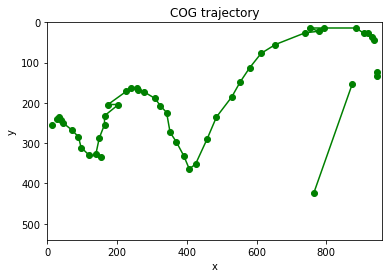

In [24]:
%matplotlib inline
plt.title('COG trajectory')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim([540, 0])
plt.xlim([0, 960])
plt.plot(COG[:,1],COG[:,0],"-o",color="g")
plt.show()

だいたい動画通りに検出できている．ノイズ除去のため，ボールが画面外にある時(LMのセル数が閾値以下の時),値は(nan,nan)としたので，ノイズも除去できている．

重心を求める際の重みは状態Lの点を３，状態Mの点を１とした．線は時系列的に連続であることを示している．

着地点と思しき点が検出できている．

###  手順3.1　移動平均による平滑化

ノイズ除去のため，buferrs数３で平滑化する

In [25]:
buffer=1
mCOG=np.full(COG.shape,np.nan)

for t in range(buffer,time[0]-buffer):
    S=0
    for i in range(2*buffer+1):
        S+=COG[t-buffer+i]
    
    mCOG[t]=S/(2*buffer+1)

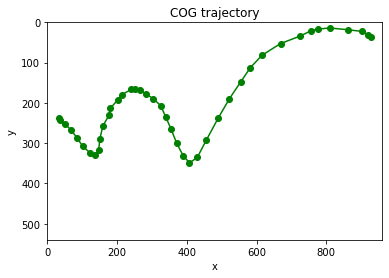

In [26]:
%matplotlib inline
plt.title('COG trajectory')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim([540, 0])
plt.xlim([0, 960])
plt.plot(mCOG[:,1],mCOG[:,0],"-o",color="g")
plt.show()

重心の軌道をアニメーションで確認する．

<IPython.core.display.Javascript object>


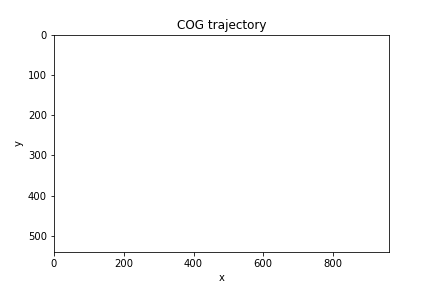

In [28]:
%matplotlib nbagg
fig2=plt.figure()
ims=[]

plt.title("COG trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim([540, 0])
plt.xlim([0, 960])

for i in range(time[0]):
    im=plt.plot(mCOG[i][1],COG[i][0],"o",color="g")
    ims.append(im)
    
ani = animation.ArtistAnimation(fig2, ims, interval=100)
plt.show()

最後に入った人の動きによるノイズを除いてほぼ直感的なボールの軌道と一致している．

### 3.1速度ベクトルの表示

重心の軌道が推定できたので，重心の速度ベクトルを求める．速度ベクトルが不連続になる点が着地点である．

時系列で先頭からチェックし，着地点と思しき時間の座標を求める．

In [29]:
bound_t=[]

vel=np.zeros((time[0]-1,2))
for t in range(time[0]-1):
    vel[t]=mCOG[t+1]-mCOG[t]

Traceback (most recent call last):
  File "/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


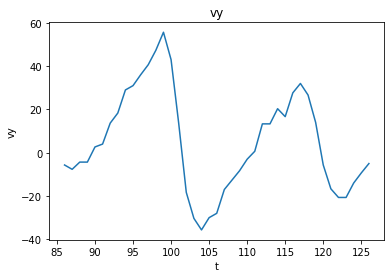

In [30]:
%matplotlib inline
plt.title("vy")
plt.xlabel("t")
plt.ylabel("vy")
tseq=np.arange(time[0]-1)

plt.plot(tseq,vel[:,0])
plt.show()

速度ベクトルが＋からーに転じる時を着地点と定義する．着地点を出力

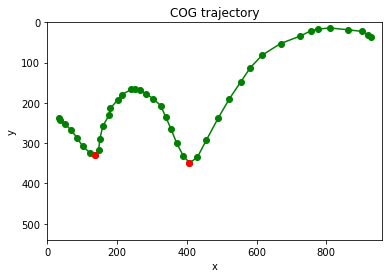

In [31]:
bound_p=np.empty((0,2))
for t in range(1,time[0]-1):
    if vel[t,0]<0 and vel[t-1,0]>=0 : 
        bound_t.append(t)
        bound_p=np.append(bound_p,mCOG[t].reshape(1,2),axis=0)

%matplotlib inline
plt.title('COG trajectory')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim([540, 0])
plt.xlim([0, 960])
plt.plot(mCOG[:,1],mCOG[:,0],"-o",color="g")
plt.plot(bound_p[:,1],bound_p[:,0],"o",color="r")
plt.show()

白線位置を示すis_white_lineと比較，白線上かどうかを判断.白線上じゃないなら右か左か出力

In [35]:
bound_p=bound_p.astype(np.int)
what_side=is_white_line[bound_p[0,0],bound_p[0,1]]
what_side

-1

-1なので着地点は左，正しく判定できている．

## ２．分類器の性能検証

以上までの手続きをクラスとしてまとめる．18個の動画について解答をフラグづけしておき，正答率を求める．
ただし，白線判定に用いたthreshold値は238で固定,各種フィルターの係数も固定する．

In [36]:
class ClassifyBallBound:
    
#ムービーとcsvのパスを取得
#csvを読み取り
#その他前処理
    def __init__(self,movie,csv):
   
        #pandasデータフレームにcsvを読み取り
        self.movie=movie
        self.df=pd.read_csv(csv,header=0,sep=',')
        self.time=self.df.shape[0]
        self.mesh_num=int(int(self.df.shape[1]-3)/12)
        
        #名前の格納
        self.LMSNs=["LMSN"]
        for i in range(1,self.mesh_num):
            self.LMSNs.append("LMSN."+str(i))

        vend="v."+str(self.mesh_num-1)
        hend="h."+str(self.mesh_num-1)
        self.vsize=self.df[vend][0]+1
        self.hsize=self.df[hend][0]+1
        
        #dfからLMSN情報を取得
        self.state=[]

        for i in range(mesh_num):
            self.state.append(self.df[self.LMSNs[i]])
    
#0フレーム目を返す関数（白線検出に使用）
    def return_frame(self,video_path, frame_num):
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print("movie roding error !")

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)#パラメータCAP_PROP_POS_FRAMESにframe_numを指定

        ret, frame = cap.read() #frame_num番目の画像を取得

        if not ret :
            print("movie roding error !")

        return frame

#白線のみ抽出する関数(白線検出に使用)
    def get_whiteline(self,img,th,rate):

        u=th+rate
        l=th-rate

        U=img<u
        L=img>l

        temp=np.logical_and(U,L)

        is_white_line=temp.astype(np.int)

        white_line=is_white_line*img

        white_line=white_line.astype(np.uint8)

        return white_line,is_white_line

##手順１##################################################
    def extract_whiteline(self,threshold,rate):
        
        #白線の読み取り
        frame0=self.return_frame(self.movie,0)
        gray_frame0= cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
        cv2.imwrite('/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/frame0s/frame0.jpg', frame0)
        cv2.imwrite('/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/gray_frame0s/gray_frame0.jpg', gray_frame0)
        self.cellvsize=np.shape(gray_frame0)[0]
        self.cellhsize=np.shape(gray_frame0)[1]
        
        white_line,is_white_line=self.get_whiteline(gray_frame0,threshold,rate)
        blur = cv2.GaussianBlur(white_line,(5,5),0)
        self.white_line,self.is_white_line=self.get_whiteline(blur,threshold,rate)

        for i in range(self.is_white_line.shape[0]):
            flag=0
            for j in range(self.is_white_line.shape[1]):
                if self.is_white_line[i,j]==1 and j>200:
                    flag=1
                if flag==0:
                    self.is_white_line[i,j]=-1
        
        return self.white_line,self.is_white_line
    
    
##手順２#################################################
##手順３#################################################
    def expect_bound(self,wrate,filtrate,buffer):
        
        #各時間，各メッシュでのボールの有無
        ball=np.zeros((self.time,self.vsize,self.hsize))
        for t in range(self.time):
            temp=np.zeros(self.mesh_num)
            for i in range(self.mesh_num):
                if self.state[i][t]=="L" :
                    temp[i]=2
                elif self.state[i][t]=="M":
                    temp[i]=1
            ball[t]=np.reshape(temp,(self.vsize,self.hsize))
            
            
        #各時間，各セルでのボールの有無
        cellball=np.zeros((self.time,self.cellvsize,self.cellhsize))

        #ボールの位置（セル）
        self.ballpos=[]

        #ボールの重心（セル）
        self.COG=np.zeros((self.time,2))

        #L:Mの時の重み
        wrate

        dv=int(self.cellvsize/self.vsize)
        dh=int(self.cellhsize/self.hsize)

        #活性化メッシュのノイズフィルター（閾値以下のセル数で除去）
        filt=dv*dh*filtrate

        for t in range(self.time):
            for i in range(self.vsize):
                for j in range(self.hsize):
                    if ball[t,i,j]==1:
                        cellball[t][i*dv:(i+1)*dv,j*dh:(j+1)*dh]=np.ones((dv,dh))
                    elif ball[t,i,j]==2:
                        cellball[t][i*dv:(i+1)*dv,j*dh:(j+1)*dh]=2*np.ones((dv,dh))

            pointL=np.where(cellball[t]==2)
            pointL=np.array(pointL)

            pointM=np.where(cellball[t]==1)
            pointM=np.array(pointM)

            point=np.append(pointL,pointM,axis=1)

            w=np.append(wrate*np.ones(pointL.shape[1]),np.ones(pointM.shape[1]))

            #ボールが存在しないtの時は(nan,nan)とする,filt以下のセル数しか活性化してないなら画面内にボールは存在しない
            if point.shape[1]<filt:
                self.COG[t]=np.array([np.nan,np.nan])
                self.ballpos.append(np.array([[np.nan],[np.nan]]))
            else:
                self.COG[t]=np.average(point,axis=1,weights=w).astype(np.int)
                self.ballpos.append(point)
        
        #移動平均
        self.mCOG=np.full(self.COG.shape,np.nan)
        for t in range(buffer,self.time-buffer):
            S=0
            for i in range(2*buffer+1):
                S+=self.COG[t-buffer+i]

            self.mCOG[t]=S/(2*buffer+1)
                
        self.bound_t=np.array([])
        self.vel=np.zeros((self.time-1,2))
        for t in range(self.time-1):
            self.vel[t]=self.mCOG[t+1]-self.mCOG[t]
            
        self.bound_p=np.empty((0,2))
        for t in range(1,self.time-1):
            if  self.vel[t,0]<0 and self.vel[t-1,0]>=0 :
                self.bound_t=np.append(self.bound_t,t)
                self.bound_p=np.append(self.bound_p,self.mCOG[t].reshape(1,2),axis=0)   
        
        if self.bound_p.shape[0]==0:
            print("sample is lack.(maybe buffer is too big)")
            return np.array([np.nan,np.nan])
        else:
            return self.bound_p,self.mCOG
    
##手順４#################################################
    def judge_where(self):

        if self.bound_p.shape[0]==0:
            return np.nan
        else:
            self.bound_p=self.bound_p.astype(np.int) 
            self.what_side=self.is_white_line[self.bound_p[0,0],self.bound_p[0,1]]
            return self.what_side

## 2.1データのラベルづけ

データの名前そのものにラベルが振ってあるのでそれを取ってくる．

In [37]:
label=np.zeros(len(csv),dtype=np.int)
filename=[]
for i in range(len(csv)):
    k=len("/Users/daigofujiwara/Documents/ICSP/ICSP_contest0706/csv/")
    temp=csv[i][k:]
    temp=temp.rstrip(".csv")
    filename.append(temp)
    
    if temp.find("far")>=0:
        if temp.lstrip("far")[0]=="-":
            label[i]=-1
        elif temp.lstrip("far")[0]=="0":
            label[i]=0
        elif temp.lstrip("far")[0]=="1":
            label[i]=1
            
    
    elif temp.find("mid")>=0:
        if temp.lstrip("mid")[0]=="-":
            label[i]=-1
        elif temp.lstrip("mid")[0]=="0":
            label[i]=0
        elif temp.lstrip("mid")[0]=="1":
            label[i]=1
                       
    elif temp.find("near")>=0:
        if temp.lstrip("near")[0]=="-":
            label[i]=-1
        elif temp.lstrip("near")[0]=="0":
            label[i]=0
        elif temp.lstrip("near")[0]=="1":
            label[i]=1
                       
label[0]

-1

## テスト
さあ実際に評価をやっていきましょう！

In [38]:
CBB=[]

count=0
correct=0
moving_average_buffere=1

for i in range(len(csv)):
    cbb=ClassifyBallBound(movie[i],csv[i])
    CBB.append(cbb)
    cbb.extract_whiteline(240,30)
    cbb.expect_bound(4,3,moving_average_buffere)
    predict=cbb.judge_where()
    print("label= ",label[i]," predict= ",predict," filename= ",filename[i])
    count+=1
    if label[i]==predict:
        correct+=1
print("acuracy=",correct/count)

label=  -1  predict=  -1  filename=  far-1
label=  -1  predict=  -1  filename=  far-11
label=  -1  predict=  -1  filename=  far-12
label=  0  predict=  0  filename=  far0
label=  0  predict=  0  filename=  far01
label=  0  predict=  0  filename=  far02
label=  0  predict=  0  filename=  far03
label=  0  predict=  0  filename=  far04
label=  1  predict=  0  filename=  far1
label=  1  predict=  0  filename=  far11
label=  -1  predict=  0  filename=  mid-1
label=  -1  predict=  1  filename=  mid-11
label=  -1  predict=  0  filename=  mid-12
label=  0  predict=  0  filename=  mid0
label=  -1  predict=  -1  filename=  near-1
label=  0  predict=  -1  filename=  near0
acuracy= 0.625


farは遠目のアングル，midは中ぐらい，nearは近くで取ったデータを表す

## うまくいかない時の例

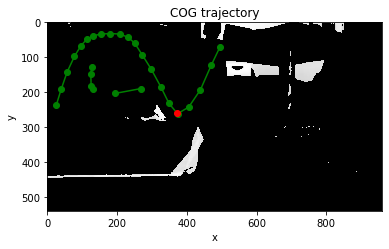

In [39]:
%matplotlib inline
k=10
plt.title('COG trajectory')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim([540, 0])
plt.xlim([0, 960])
plt.plot(CBB[k].mCOG[:,1],CBB[k].mCOG[:,0],"-o",color="g")
plt.plot(CBB[k].bound_p[:,1],CBB[k].bound_p[:,0],"o",color="r")
plt.imshow(cv2.cvtColor(CBB[k].white_line, cv2.COLOR_BGR2RGB))
plt.show()
plt.show()

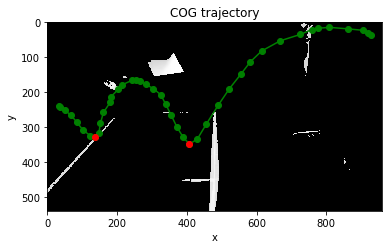

In [41]:
%matplotlib inline
k=0
plt.title('COG trajectory')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim([540, 0])
plt.xlim([0, 960])
plt.plot(CBB[k].mCOG[:,1],CBB[k].mCOG[:,0],"-o",color="g")
plt.plot(CBB[k].bound_p[:,1],CBB[k].bound_p[:,0],"o",color="r")
plt.imshow(cv2.cvtColor(CBB[k].white_line, cv2.COLOR_BGR2RGB))
plt.show()
plt.show()